# Wildfire Modeling Workflow: Rothermel's rate of spread and flame length models
This notebook computes Rothermel surface fire rate of spread (ROS) and flame length rasters from a DEM and LANDFIRE fuel model raster using constant wind and fuel moisture inputs. The ouputs could be used for applications such as prescribed burn planning, city design, and hazard mitigation.

Nate Dailey - 2/27/2026

## Setup (Python 3.10 venv)

The package that this script uses for its wildfire modeling calculations, `pyretechnics`, does not work on the newest versions of Python. It only works on Python 3.10 and 3.11, so one of these two older versions must be used. 

### Windows (PowerShell)
```powershell
py -3.10 -m venv .venv
.\.venv\Scripts\Activate.ps1
python -m pip install --upgrade pip
pip install -r requirements.txt
```

### Linux / macOS (bash/zsh)
```bash
python3.10 -m venv .venv
source .venv/bin/activate
python -m pip install --upgrade pip
pip install -r requirements.txt
```

# 1. Set Paths, Constants, and Runtime Configuration
Configuration for inputs, outputs, units, constants, and filtering behavior.

In [50]:
DEM_PATH = r"processed_data\dem_resampled.tif"
FUEL_MODEL_PATH = r"processed_data\LF_aoi.tif"
MODEL_PARAMETERS_CSV_PATH = r"model_parameters_scott_and_burgan_2005.csv"

ROS_OUT_PATH = r"outputs\02272026\ros_2.tif"
FL_OUT_PATH = r"outputs\02272026\flame_length_m_2.tif"
    
WIND_SPEED_UNITS = "mps"
WIND_SPEED_CONSTANT = 10.0
WIND_DIRECTION_CONSTANT = 270.0
WIND_DIR_IS_FROM = True

MOISTURE_UNITS = "fraction"
FUEL_MOISTURE_CONSTANT = 0.08
DEAD_10HR_MULT = 1.5
DEAD_100HR_MULT = 2.0
LIVE_HERB_MOISTURE = 0.90
LIVE_WOODY_MOISTURE = 0.60
MOISTURE_MIN = 0.0
MOISTURE_MAX = 3.0

NONBURNABLE_CODES = {0, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}

# 2. Import Dependencies and Define Fuel Model Mappings
Imports and canonical FBFM40 ID mapping plus expected CSV schema headers.

In [51]:
import math
import csv
import numpy as np
import rasterio
import pyretechnics.conversion as conv
import pyretechnics.fuel_models as fm
import pyretechnics.surface_fire as sf

fuel_model_codes = {
    91: "NB1", 93: "NB3", 98: "NB8", 99: "NB9",
    101: "GR1", 102: "GR2", 103: "GR3",
    121: "GS1", 122: "GS2",
    141: "SH1", 142: "SH2", 143: "SH3", 144: "SH4", 145: "SH5", 146: "SH6", 147: "SH7",
    161: "TU1", 162: "TU2", 163: "TU3", 165: "TU5",
    181: "TL1", 182: "TL2", 183: "TL3", 184: "TL4", 185: "TL5", 186: "TL6", 187: "TL7", 188: "TL8", 189: "TL9",
    201: "SB1", 202: "SB2",
}

EXPECTED_MODEL_PARAMETER_COLUMNS = (
    "fuel model number",
    "fuel model code",
    "1-hr fuel load",
    "10-hr fuel load",
    "100-hr fuel load",
    "live herb fuel load",
    "live woody fuel load",
    "fuel model type",
    "1-hr surface area/vol ratio",
    "herb. surface area/vol ratio",
    "live woody surface area/vol ratio",
    "Fuel Bed Depth",
    "Dead fuel moisture of Ext.",
    "dead fuel heat content",
    "live fuel heat content",
    "fuel model name",
)

# 3. Quick View of Input TIFFs
Preview the DEM and fuel model input rasters before running the workflow.

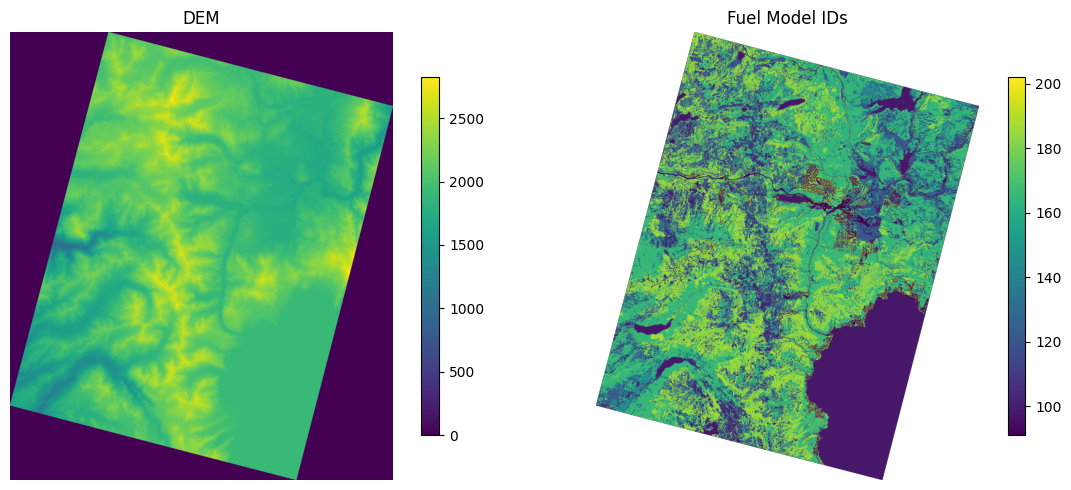

In [52]:
import os
import matplotlib.pyplot as plt


def _read_first_band_for_plot(path: str):
    with rasterio.open(path) as src:
        arr = src.read(1)
        nodata = src.nodata
    if nodata is not None:
        arr = np.where(arr == nodata, np.nan, arr)
    return arr


input_layers = [
    ("DEM", DEM_PATH),
    ("Fuel Model IDs", FUEL_MODEL_PATH),
]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (title, path) in zip(axes, input_layers):
    if not os.path.exists(path):
        ax.set_title(f"{title}\nMissing: {path}")
        ax.axis("off")
        continue

    band = _read_first_band_for_plot(path)
    image = ax.imshow(band, cmap="viridis")
    ax.set_title(title)
    ax.axis("off")
    plt.colorbar(image, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

# 3. Define Raster I/O Utility for Writing Output Grids
Helper for writing single-band float32 outputs with nodata/compression settings.

In [53]:
def write_like(src_profile: dict, out_path: str, arr: np.ndarray, nodata: float = -9999.0) -> None:
    prof = src_profile.copy()
    prof.update(
        dtype="float32",
        count=1,
        nodata=nodata,
        compress="deflate",
        predictor=2,
        tiled=True,
        bigtiff="if_safer",
    )
    out = arr.astype("float32")
    out = np.where(np.isfinite(out), out, nodata).astype("float32")
    with rasterio.open(out_path, "w", **prof) as dst:
        dst.write(out, 1)

# 4. Define Terrain Derivation Function (Slope/Aspect from DEM)
Finite-difference terrain derivation for slope (rise/run) and aspect (degrees clockwise from North).

In [54]:
def slope_aspect_from_dem(dem_m: np.ndarray, transform) -> tuple[np.ndarray, np.ndarray]:
    dx = float(transform.a)
    dy = abs(float(transform.e))
    dz_dy, dz_dx = np.gradient(dem_m, dy, dx)

    slope_rise_run = np.sqrt(dz_dx**2 + dz_dy**2).astype("float32")
    aspect_rad = np.arctan2(-dz_dx, dz_dy)
    aspect_rad = np.where(aspect_rad < 0, 2 * np.pi + aspect_rad, aspect_rad)
    aspect_deg = np.degrees(aspect_rad).astype("float32")

    return slope_rise_run, aspect_deg

# 5. Define Input Validation Helpers (CSV Header + Raster Grid Checks)
Validation helpers for CSV schema and raster compatibility checks.

In [55]:
def validate_model_parameter_csv_headers(csv_path: str) -> None:
    with open(csv_path, "r", newline="", encoding="utf-8-sig") as f:
        reader = csv.DictReader(f)
        headers = reader.fieldnames or []

    missing = [col for col in EXPECTED_MODEL_PARAMETER_COLUMNS if col not in headers]
    if missing:
        raise ValueError(
            "Model parameter CSV is missing required columns: "
            f"{missing}. Found columns: {headers}"
        )


def validate_raster_compatibility(dem_src, fm_src) -> None:
    if dem_src.count != 1:
        raise ValueError(f"DEM must contain exactly 1 band of elevation values; found {dem_src.count} bands.")
    if fm_src.count != 1:
        raise ValueError(f"Fuel model raster must contain exactly 1 band of ID values; found {fm_src.count} bands.")
    if (dem_src.width, dem_src.height) != (fm_src.width, fm_src.height):
        raise ValueError("Raster dimensions do not match. Reproject/resample to a common grid first.")
    if dem_src.transform != fm_src.transform:
        raise ValueError("Raster transforms do not match. Reproject/resample to a common grid first.")

# 6. Define Unit Conversion and Wind Direction Helpers
Convert wind speed to m/min and normalize direction to upwind direction.

In [56]:
def wind_speed_to_m_min(ws: np.ndarray) -> np.ndarray:
    ws = ws.astype("float32")
    if WIND_SPEED_UNITS == "mps":
        return ws * 60.0
    if WIND_SPEED_UNITS == "kmhr":
        return conv.km_hr_to_m_min(ws)
    if WIND_SPEED_UNITS == "mph":
        return ws * 0.44704 * 60.0
    raise ValueError(f"Unknown WIND_SPEED_UNITS: {WIND_SPEED_UNITS}")


def upwind_dir_deg(wd_deg: np.ndarray) -> np.ndarray:
    wd = wd_deg.astype("float32") % 360.0
    if WIND_DIR_IS_FROM:
        return wd
    return (wd + 180.0) % 360.0

# 7. Define Moisture Expansion Helper (1 Value to 6-Component Tuple)
Expand one moisture value into the six-component tuple expected by Pyretechnics.

In [57]:
def moisture_tuple_from_one_value(m: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    m = m.astype("float32")
    if MOISTURE_UNITS == "percent":
        m = m / 100.0
    m = np.clip(m, MOISTURE_MIN, MOISTURE_MAX)

    dead_1hr = m
    dead_10hr = np.clip(m * DEAD_10HR_MULT, MOISTURE_MIN, MOISTURE_MAX)
    dead_100hr = np.clip(m * DEAD_100HR_MULT, MOISTURE_MIN, MOISTURE_MAX)
    dead_herb = np.zeros_like(m, dtype="float32")
    live_herb = np.full_like(m, LIVE_HERB_MOISTURE, dtype="float32")
    live_woody = np.full_like(m, LIVE_WOODY_MOISTURE, dtype="float32")

    return dead_1hr, dead_10hr, dead_100hr, dead_herb, live_herb, live_woody

# 8. Load DEM and Fuel Model Rasters, Build Masks, and Precompute Inputs
Read raster inputs, build masks, derive terrain fields, and create constant wind/moisture arrays.

In [58]:
def load_and_prepare_inputs() -> dict:
    validate_model_parameter_csv_headers(MODEL_PARAMETERS_CSV_PATH)

    with rasterio.open(DEM_PATH) as dem_src, rasterio.open(FUEL_MODEL_PATH) as fm_src:
        validate_raster_compatibility(dem_src, fm_src)

        profile = dem_src.profile
        dem = dem_src.read(1).astype("float32")
        fuel_model = fm_src.read(1).astype("int32")

        def bad(a: np.ndarray) -> np.ndarray:
            return ~np.isfinite(a) | (a <= -1e20)

        nodata_mask = bad(dem) | (fuel_model <= 0)

        slope_rise_run, aspect_deg = slope_aspect_from_dem(dem, dem_src.transform)

        wind_speed_const = np.full(dem.shape, WIND_SPEED_CONSTANT, dtype="float32")
        wind_dir_const = np.full(dem.shape, WIND_DIRECTION_CONSTANT, dtype="float32")
        midflame_wind_m_min = wind_speed_to_m_min(wind_speed_const)
        upwind_deg = upwind_dir_deg(wind_dir_const)

        moist = np.full(dem.shape, FUEL_MOISTURE_CONSTANT, dtype="float32")
        d1, d10, d100, dherb, lherb, lwood = moisture_tuple_from_one_value(moist)

        ros = np.full(dem.shape, np.nan, dtype="float32")
        flame = np.full(dem.shape, np.nan, dtype="float32")

    return {
        "profile": profile,
        "dem": dem,
        "fuel_model": fuel_model,
        "nodata_mask": nodata_mask,
        "slope_rise_run": slope_rise_run,
        "aspect_deg": aspect_deg,
        "midflame_wind_m_min": midflame_wind_m_min,
        "upwind_deg": upwind_deg,
        "d1": d1,
        "d10": d10,
        "d100": d100,
        "dherb": dherb,
        "lherb": lherb,
        "lwood": lwood,
        "ros": ros,
        "flame": flame,
    }

# 9. Compute ROS and Flame Length by Fuel Model Code
Iterate by unique fuel IDs, skip nonburnable/unmapped IDs, and compute ROS/flame length using Pyretechnics.

In [59]:
def compute_ros_and_flame(ctx: dict) -> dict:
    fuel_model = ctx["fuel_model"]
    nodata_mask = ctx["nodata_mask"]
    ros = ctx["ros"]
    flame = ctx["flame"]

    d1 = ctx["d1"]
    d10 = ctx["d10"]
    d100 = ctx["d100"]
    dherb = ctx["dherb"]
    lherb = ctx["lherb"]
    lwood = ctx["lwood"]

    midflame_wind_m_min = ctx["midflame_wind_m_min"]
    upwind_deg = ctx["upwind_deg"]
    slope_rise_run = ctx["slope_rise_run"]
    aspect_deg = ctx["aspect_deg"]

    nonburnable_ids = set()
    unmapped_ids = set()
    lookup_failed_ids = set()
    processed_ids = set()

    unique_codes = np.unique(fuel_model[~nodata_mask])
    for code in unique_codes:
        fuel_id = int(code)
        if fuel_id in NONBURNABLE_CODES:
            nonburnable_ids.add(fuel_id)
            continue

        fuel_model_code = fuel_model_codes.get(fuel_id)
        if fuel_model_code is None:
            unmapped_ids.add(fuel_id)
            continue

        try:
            base_fuel = fm.get_fuel_model(fuel_id)
        except Exception:
            lookup_failed_ids.add(fuel_id)
            continue

        processed_ids.add(fuel_id)
        sel = (fuel_model == code) & (~nodata_mask)
        if not np.any(sel):
            continue

        idxs = np.argwhere(sel)
        for (r, c) in idxs:
            m_tuple = (
                float(d1[r, c]),
                float(d10[r, c]),
                float(d100[r, c]),
                float(dherb[r, c]),
                float(lherb[r, c]),
                float(lwood[r, c]),
            )

            mf = fm.moisturize(base_fuel, m_tuple)
            sf_min = sf.calc_surface_fire_behavior_no_wind_no_slope(mf)
            sf_max = sf.calc_surface_fire_behavior_max(
                sf_min,
                float(midflame_wind_m_min[r, c]),
                float(upwind_deg[r, c]),
                float(slope_rise_run[r, c]),
                float(aspect_deg[r, c]),
                surface_lw_ratio_model="rothermel",
            )

            ros[r, c] = float(sf_max["max_spread_rate"])
            flame[r, c] = float(sf_max["max_flame_length"])

    ctx["unique_codes"] = unique_codes
    ctx["processed_ids"] = processed_ids
    ctx["nonburnable_ids"] = nonburnable_ids
    ctx["unmapped_ids"] = unmapped_ids
    ctx["lookup_failed_ids"] = lookup_failed_ids
    return ctx

# 10. Write Output Rasters and Print Processing Summary
Write ROS and flame outputs, and print processed/skipped fuel ID diagnostics.

In [60]:
def write_and_summarize(ctx: dict) -> None:
    write_like(ctx["profile"], ROS_OUT_PATH, ctx["ros"])
    write_like(ctx["profile"], FL_OUT_PATH, ctx["flame"])

    print("Fuel ID summary:")
    print(f"  unique IDs in raster (valid area): {len(ctx['unique_codes'])}")
    print(f"  processed IDs: {len(ctx['processed_ids'])}")
    print(f"  nonburnable IDs skipped: {len(ctx['nonburnable_ids'])} -> {sorted(ctx['nonburnable_ids'])}")
    if ctx["unmapped_ids"]:
        print(f"  WARNING: unmapped IDs skipped: {len(ctx['unmapped_ids'])} -> {sorted(ctx['unmapped_ids'])}")
    if ctx["lookup_failed_ids"]:
        print(f"  WARNING: lookup-failed IDs skipped: {len(ctx['lookup_failed_ids'])} -> {sorted(ctx['lookup_failed_ids'])}")

    print("Done.")
    print(f"ROS (m/min): {ROS_OUT_PATH}")
    print(f"Flame length (m): {FL_OUT_PATH}")

In [61]:
def run_workflow() -> None:
    ctx = load_and_prepare_inputs()
    ctx = compute_ros_and_flame(ctx)
    write_and_summarize(ctx)


# Execute end-to-end run
run_workflow()

Fuel ID summary:
  unique IDs in raster (valid area): 28
  processed IDs: 24
  nonburnable IDs skipped: 3 -> [91, 98, 99]
Done.
ROS (m/min): outputs\02272026\ros_2.tif
Flame length (m): outputs\02272026\flame_length_m_2.tif


# 13. Display Output TIFFs
Quick-look plots for ROS and flame length output rasters.

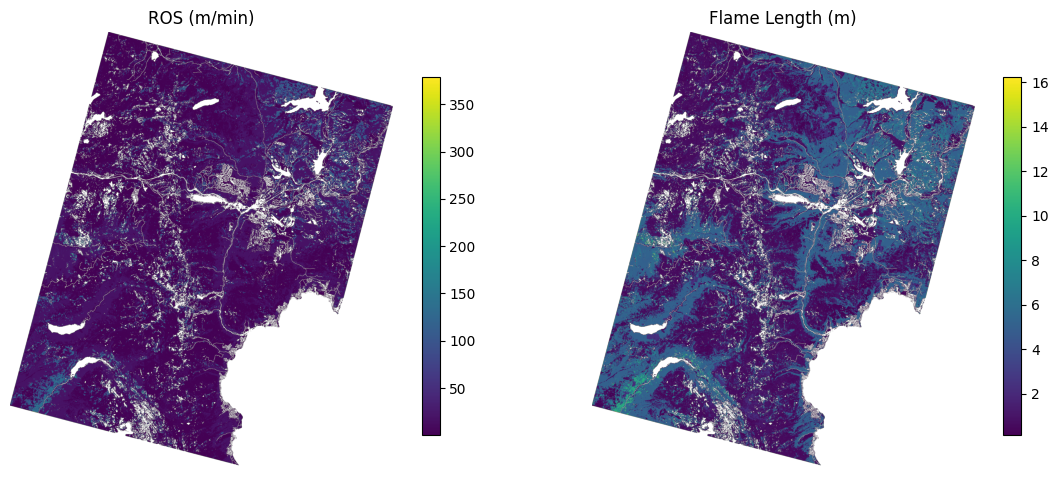

In [62]:
import os
import matplotlib.pyplot as plt


def _read_first_band(path: str):
    with rasterio.open(path) as src:
        arr = src.read(1)
        nodata = src.nodata
    if nodata is not None:
        arr = np.where(arr == nodata, np.nan, arr)
    return arr


output_layers = [
    ("ROS (m/min)", ROS_OUT_PATH),
    ("Flame Length (m)", FL_OUT_PATH),
]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (title, path) in zip(axes, output_layers):
    if not os.path.exists(path):
        ax.set_title(f"{title}\nMissing: {path}")
        ax.axis("off")
        continue

    band = _read_first_band(path)
    image = ax.imshow(band, cmap="viridis")
    ax.set_title(title)
    ax.axis("off")
    plt.colorbar(image, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()